### Chap 6 Bayes Classification

In [1]:
import os
PROJECT = 'valak01227408' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'valak' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-west2-a' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

os.environ['BUCKET'] = BUCKET

In [2]:
#!env

#### Exploration using BigQuery

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time 
from pprint import pprint as pp

import google.datalab.bigquery as bq

import warnings
warnings.filterwarnings('ignore')

In [4]:
ts_glob = time.time()

In [5]:
#this query uses 0.1 % of  flights data
#filters on dep_delay and distance are reasonable cut-offs
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
AND dep_delay > -30 AND dep_delay < 30 AND distance < 2000
"""
df = bq.Query(sql).execute().result().to_dataframe()

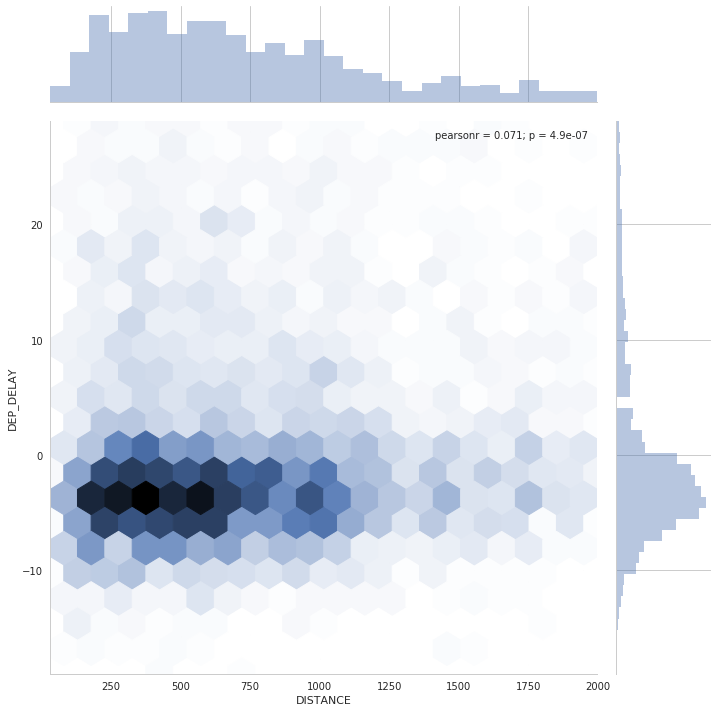

In [6]:
#viz of joint probability
sns.set_style("whitegrid")
g = sns.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind="hex", size=10, joint_kws={'gridsize':20})


#### Setting up views in Spark SQL

In [7]:
print spark

In [8]:
#the way to creaete a spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bayes classification using Spark") \
    .getOrCreate()
print spark

In [9]:
##create a schema of tzcorr files

from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])

print schema

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

In [10]:
#inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # just 1 of 30 files 
inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET) #all files in the tzcorr
s =time.time()
flights = spark.read\
            .schema(schema)\
            .csv(inputs)
e=time.time()
pp("spark reading took {}".format(e-s))
# this view can now be queried ...
flights.createOrReplaceTempView('flights')

'spark reading took 3.62845993042'


In [11]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND distance < 2000')
results.show()

+--------+
|count(1)|
+--------+
| 5762824|
+--------+



In [12]:
#res = spark.sql('SELECT * from flights where dep_delay > -20 and distance < 2000 limit 5')
#res.show()

#### Restrict to train days

Create a csv file of the training days from flights.trainday bq table

In [13]:
sql = """
SELECT *
FROM `flights.trainday`
"""
df = bq.Query(sql).execute().result().to_dataframe()
df.to_csv('trainday.csv', index=False)

!ls  -l  # a file is created in a current dir

total 288
-rw-r--r-- 1 root root  99507 May 12 16:52 quantization_fulldata_szi.ipynb
-rw-r--r-- 1 root root 182927 May 12 16:46 quantization_szi.ipynb
-rw-r--r-- 1 root root   6470 May 12 16:52 trainday.csv


In [14]:

!head -3 trainday.csv

FL_DATE,is_train_day
2015-01-01,True
2015-01-02,False


In [15]:
%bash
gsutil cp trainday.csv gs://${BUCKET}/flights/trainday.csv

Copying file://trainday.csv [Content-Type=text/csv]...
/ [1 files][  6.3 KiB/  6.3 KiB]                                                
Operation completed over 1 objects/6.3 KiB.                                      


In [16]:
traindays = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

traindays.createOrReplaceTempView('traindays')

In [17]:
results = spark.sql('SELECT * FROM traindays')
results.head(5)

[Row(FL_DATE=datetime.datetime(2015, 1, 1, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 2, 0, 0), is_train_day=False),
 Row(FL_DATE=datetime.datetime(2015, 1, 3, 0, 0), is_train_day=False),
 Row(FL_DATE=datetime.datetime(2015, 1, 4, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 5, 0, 0), is_train_day=True)]

In [18]:
#limit flights to training set
statement = """
SELECT
  f.FL_DATE AS date,
  distance,
  dep_delay
FROM flights f
INNER JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day AND
  f.dep_delay IS NOT NULL
ORDER BY
  f.dep_delay DESC
"""
flights = spark.sql(statement)

In [19]:
flights.head(2)

[Row(date=u'2015-08-01', distance=1158.0, dep_delay=1878.0),
 Row(date=u'2016-01-31', distance=1345.0, dep_delay=1663.0)]

#### HEXbin plot 

Create a the same hexbin plot as in BigQuery using a spark  but on train days only


In [20]:
df = flights[(flights['distance'] < 2000) & (flights['dep_delay'] > -20) & (flights['dep_delay'] < 30)]
df.describe().show()

+-------+----------+------------------+--------------------+
|summary|      date|          distance|           dep_delay|
+-------+----------+------------------+--------------------+
|  count|   3638261|           3638261|             3638261|
|   mean|      null| 711.8030575596418|-0.21208896228170546|
| stddev|      null|442.63295949480573|   8.226719283838538|
|    min|2015-01-01|              31.0|               -19.0|
|    max|2016-01-31|            1999.0|                29.0|
+-------+----------+------------------+--------------------+



'viz took 0.339629888535'


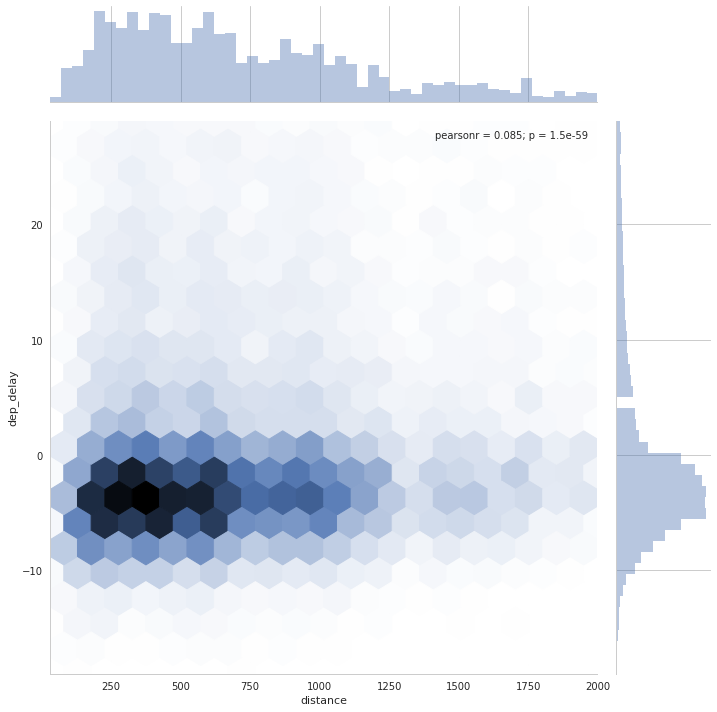

In [21]:
#sample(withReplacement=None, fraction=None, seed=None)[source]¶
pdf = df.sample(False, 0.01, 20).toPandas()  #conv spark df to pandas df  #expected to have ~ 1K rows
s=time.time()
g = sns.jointplot(pdf['distance'], pdf['dep_delay'], kind="hex", size=10, joint_kws={'gridsize':20})
e=time.time()
pp('viz took {}'.format(e-s))

#### Quantization 

now find the quantiles

In [22]:
#approxQuantile(col, probabilities, relativeError)
distthresh = flights.approxQuantile('distance', list(np.arange(0, 1.0, 0.1)), 0.02)
pp(distthresh)

[31.0, 239.0, 363.0, 452.0, 576.0, 738.0, 852.0, 1011.0, 1222.0, 2065.0]


In [23]:
delaythresh = flights.approxQuantile('dep_delay', list(np.arange(0, 1.0, 0.1)), 0.05)
delaythresh

[-82.0, -8.0, -5.0, -4.0, -3.0, -2.0, 0.0, 6.0, 23.0, 34.0]

In [24]:
statement= """
SELECT COUNT(*)
FROM flights
WHERE dep_delay >= 3 AND dep_delay < 8 
AND distance >= 447 AND distance < 557
"""

results = spark.sql(statement)
results.show()

AnalysisException: u"Database 'default' not found;"

In [ ]:
te_glob=time.time()
pp("quantization notebook on all dataset took {}".format(te_glob - ts_glob))